In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def prep(df):
    agg = {
        'size_main': 'sum',
        'size_fsm': 'sum'
    }
    return df.groupby(['schemaname', 'indexname']).agg(agg)



# Index sizes in PG11 and PG12

The following compares the index sizes across PG11 and PG12. In both versions, we loaded data using COPY after having fully initialized the database schema and created indexes.

In [3]:
def index_overhead(before, after, section):
    overhead = before[section].sum() / after[section].sum()
    print("Total overhead ratio (indexes are larger by this factor): %.02f" % (overhead))

    size_diff = before[section].sum() - after[section].sum()
    print("Total index overhead in size: %d MB" % (size_diff / (1024**2)))
    
    print("Total real index size (in PG12): %d GB" % (after[section].sum() / (1024**3)))
    
before = prep(pd.read_csv('pg11-incremental-load/index-sizes.csv'))
after = prep(pd.read_csv('pg12-incremental-load/index-sizes.csv'))    

index_overhead(before, after, 'size_main')

Total overhead ratio (indexes are larger by this factor): 1.07
Total index overhead in size: 120631 MB
Total real index size (in PG12): 1683 GB


In [4]:
cols = ['schemaname', 'indexname', 'size_main']
a = before.reset_index()[cols]
b = after.reset_index()[cols]

# "bloated" refers to PG11 sizes
# "real" refers to PG12 sizes

df = pd.merge(a, b, on=['schemaname', 'indexname'], how='outer')
df.rename(columns={'size_main_x': 'pg11_size', 'size_main_y': 'pg12_size'}, inplace=True)

df['overhead'] = df['pg11_size'] / df['pg12_size']
df['overhead_in_gb'] = (df['pg11_size'] - df['pg12_size']) / 1024**3
df['pg12_size_in_gb'] = df['pg12_size'] / 1024**3

df = df.sort_values('pg12_size', ascending=False)

df.head(30)
#df.rename('size_main_x': 'orig_size')

schemaname                                          indexname  \
747      public            index_merge_request_diff_commits_on_sha   
378      public  index_ci_build_trace_sections_on_build_id_and_...   
746      public  index_merge_request_diff_commits_on_mr_diff_id...   
824      public                        index_notes_on_note_trigram   
380      public   index_ci_build_trace_sections_on_section_name_id   
379      public        index_ci_build_trace_sections_on_project_id   
390      public  index_ci_builds_on_commit_id_and_type_and_name...   
748      public  index_merge_request_diff_files_on_mr_diff_id_a...   
402      public                 index_ci_builds_on_token_encrypted   
391      public      index_ci_builds_on_commit_id_and_type_and_ref   
577      public           index_events_on_author_id_and_created_at   
580      public          index_events_on_project_id_and_created_at   
389      public   index_ci_builds_on_commit_id_and_status_and_type   
122      public  analytics_index_events_on_created_at_and_autho...   
1045     public              index_sent_notifications_on_reply_key   
158      public                   ci_builds_gitlab_monitor_metrics   
822      public                       index_notes_on_discussion_id   
406      public  index_ci_builds_on_user_id_and_created_at_and_...   
394      public     index_ci_builds_on_project_id_and_name_and_ref   
400      public   index_ci_builds_on_status_and_type_and_runner_id   
581      public                  index_events_on_project_id_and_id   
388      public  index_ci_builds_on_commit_id_and_stage_idx_and...   
1361     public                                       taggings_idx   
231      public                                        events_pkey   
578      public           index_events_on_author_id_and_project_id   
412      public     index_ci_job_artifacts_on_expire_at_and_job_id   
582      public          index_events_on_target_type_and_target_id   
393      public               index_ci_builds_on_project_id_and_id   
819      public     index_notes_on_author_id_and_created_at_and_id   
403      public                      index_ci_builds_on_updated_at   

         pg11_size     pg12_size  overhead  overhead_in_gb  pg12_size_in_gb  
747   1.372330e+11  125480828928  1.093657       10.945023       116.863129  
378   7.250638e+10   88828026880  0.816256      -15.200722        82.727547  
746   1.067629e+11   73005203456  1.462401       31.439301        67.991394  
824   6.489509e+10   64895090688  1.000000        0.000000        60.438263  
380   6.977561e+10   58048987136  1.202012       10.921265        54.062332  
379   6.944359e+10   54337585152  1.278003       14.068565        50.605820  
390   4.319695e+10   43129708544  1.001559        0.062622        40.167671  
748   4.847984e+10   42162298880  1.149839        5.883667        39.266701  
402   3.380444e+10   34344935424  0.984263       -0.503372        31.986214  
391   3.244728e+10   34147835904  0.950200       -1.583771        31.802650  
577   3.121663e+10   30125064192  1.036235        1.016602        28.056152  
580   3.014339e+10   29282713600  1.029392        0.801567        27.271652  
389   2.574254e+10   26453082112  0.973140       -0.661743        24.636353  
122   2.648963e+10   26088079360  1.015392        0.373978        24.296417  
1045  2.592788e+10   25866428416  1.002376        0.057236        24.089989  
158   2.518516e+10   25118220288  1.002665        0.062340        23.393166  
822   2.354983e+10   23361470464  1.008063        0.175423        21.757065  
406   2.334165e+10   22552920064  1.034972        0.734558        21.004044  
394   2.089732e+10   21149818880  0.988061       -0.235161        19.697304  
400   2.475247e+10   20943101952  1.181891        3.547752        19.504784  
581   2.131207e+10   20704575488  1.029341        0.565773        19.282639  
388   1.979983e+10   20145258496  0.982853       -0.321709        18.761734  
1361  2.019268e+10   19239583744  1.0495

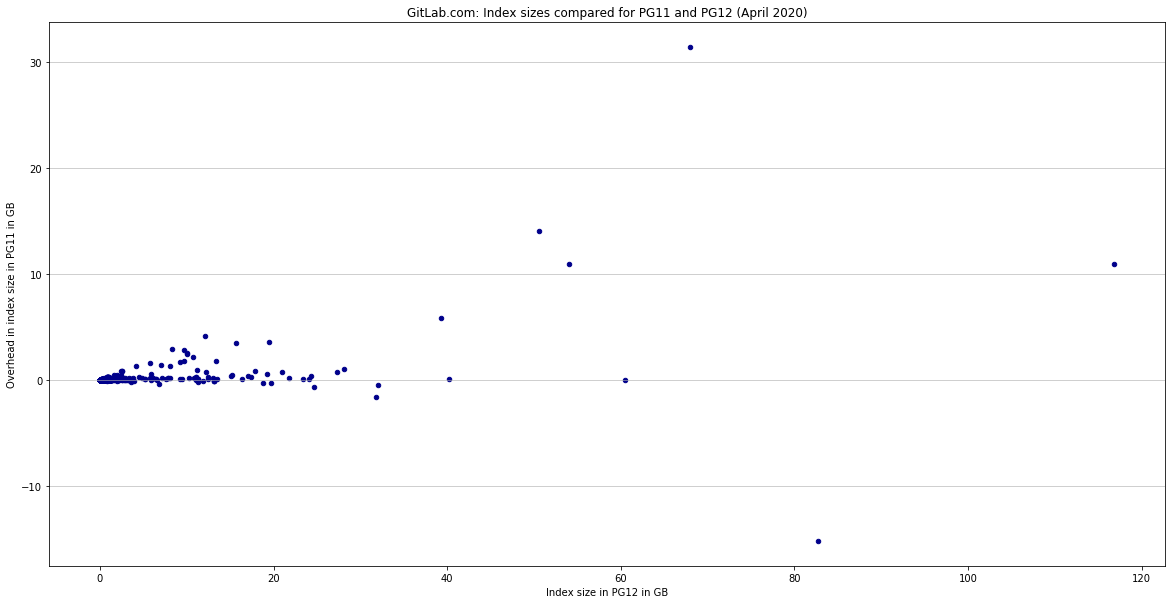

In [6]:
df.plot.scatter(x='pg12_size_in_gb',
                      y='overhead_in_gb',
                      c='DarkBlue', figsize=(20,10))

#plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Index size in PG12 in GB')
plt.ylabel('Overhead in index size in PG11 in GB')
plt.title('GitLab.com: Index sizes compared for PG11 and PG12 (April 2020)')

plt.show()